#### Merton Jump Diffusion Model
This file implements a workflow to analyze and compare the pricing of options for a given stock using the Merton Jump Diffusion model. <br>We first use rough estimates for the variables and subsequently perform optimization to minimize error.

In [16]:
import pandas as pd
import warnings
import sys
import matplotlib.pyplot as plt

from datetime import datetime
from jumpDiffusionModel import *

sys.path.insert(0, '..')

from utils import *

warnings.filterwarnings("ignore")

In [ ]:
ticker = 'AAPL'
stock_data = fetch_stock_data(ticker)
expiry, calls, puts = fetch_options_data(ticker)
expiry = pd.to_datetime(expiry)
days_to_expiry = abs((expiry - datetime.now()).days)

# Calculate midpoint here to use for testing again lastPrice
calls['midpoint'] = (calls['bid'] + calls['ask']) / 2
puts['midpoint'] = (puts['bid'] + puts['ask']) / 2

[*********************100%***********************]  1 of 1 completed


In [64]:
# Calculate the jump diffusion model metrics
underlying_price = float(stock_data['Close'].iloc[-1])
years_to_expiry = float(days_to_expiry / 365)
risk_free_rate = float(fetch_risk_free_rate()) / 100
sigma = float(calculate_historical_volatility(stock_data))

# Parameters for the Merton Jump Diffusion Model
lam = 0.5  # Jump intensity
m = 1   # Mean jump size
v = 0.2    # Jump volatility

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Jump Diffusion Process')

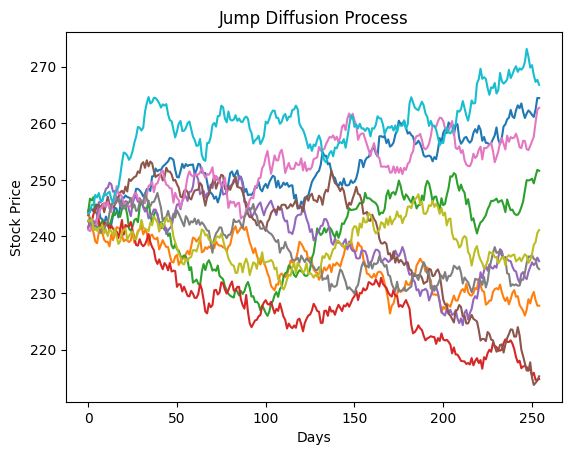

In [65]:
steps = 255 # time steps
Npaths = 10 # number of paths to simulate

price = viz_jump_paths(underlying_price, years_to_expiry, risk_free_rate, m, v, lam, steps, Npaths, sigma)

plt.plot(price)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')

In [24]:
# Create a pandas DataFrame to store the results
call_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])
put_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])

for strike, last_price in zip(calls['strike'], calls['lastPrice']):
    call_price = 0
    for k in range(50):
        call_price += jump_call(underlying_price, years_to_expiry, risk_free_rate, m, v, lam, sigma, strike, k)
        # print(call_price, last_price)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": call_price,
        "Last Price": last_price,
        "Error": abs(call_price - last_price) / last_price
    })
    call_results = pd.concat([call_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_call_error = call_results[call_results['Error'] != 1]['Error'].mean()
print(f"Average Call Error: {((average_call_error)):.2f}%")

for strike, last_price in zip(puts['strike'], puts['lastPrice']):
    put_price = 0
    for k in range(50):
        put_price += jump_put(underlying_price, years_to_expiry, risk_free_rate, m, v, lam, sigma, strike, k)
        # print(put_price, last_price)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": put_price,
        "Last Price": last_price,
        "Error": abs(put_price - last_price) / last_price
    })
    put_results = pd.concat([put_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_put_error = put_results[put_results['Error'] != 1]['Error'].mean()
print(f"Average Put Error: {((average_put_error)):.2f}%")


Average Call Error: 1.05%
Average Put Error: 1.01%


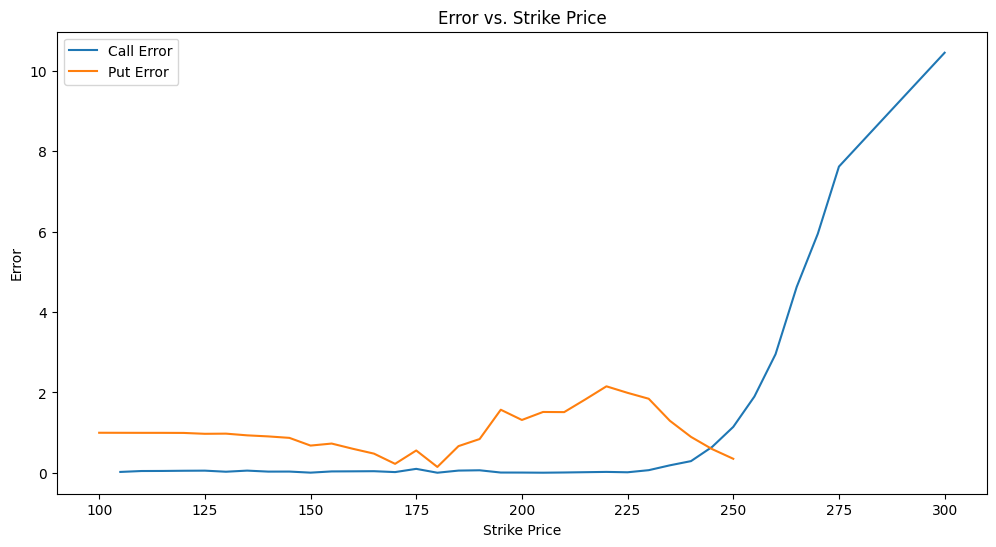

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(call_results['Strike'], call_results['Error'], label='Call Error')
plt.plot(put_results['Strike'], put_results['Error'], label='Put Error')
plt.xlabel('Strike Price')
plt.ylabel('Error')
plt.legend()
plt.title('Error vs. Strike Price')
plt.show()

**Note:** We optimize the variables by the mean absolute percentage error between calculated and actual option prices for both calls and puts.

In [28]:
from scipy.optimize import minimize

def objective_function(params):
    lam, m, v, sigma = params
    total_error = 0
    for strike, last_price in zip(calls['strike'], calls['lastPrice']):
        call_price = sum(jump_call(underlying_price, years_to_expiry, risk_free_rate, m, v, lam, sigma, strike, k) for k in range(50))
        total_error += abs(call_price - last_price) / last_price if last_price != 0 else 0
    for strike, last_price in zip(puts['strike'], puts['lastPrice']):
        put_price = sum(jump_put(underlying_price, years_to_expiry, risk_free_rate, m, v, lam, sigma, strike, k) for k in range(50))
        total_error += abs(put_price - last_price) / last_price if last_price != 0 else 0
    total_data_points = len(calls) + len(puts)
    return total_error / total_data_points if total_data_points > 0 else float('inf')

# Initial guess
initial_params = [1, 1, 0.2, 0.15]

# Bounds for parameters
bounds = [(0, 5), (0, 5), (0.01, 1), (0.01, 1)]

# Minimize the objective function
result = minimize(objective_function, initial_params, bounds=bounds, method='L-BFGS-B')

optimized_lam, optimized_m, optimized_v, optimized_sigma = result.x
print(f"Optimized Parameters: λ={optimized_lam}, m={optimized_m}, v={optimized_v}, σ={optimized_sigma}")


Optimized Parameters: λ=0.843569195961119, m=0.9551008628057229, v=0.12542181133204067, σ=0.13812224720352728


In [30]:
# Create a pandas DataFrame to store the results
opt_call_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])
opt_put_results = pd.DataFrame(columns=['Strike', 'Calculated Price', 'Last Price', 'Error'])

for strike, last_price in zip(calls['strike'], calls['lastPrice']):
    call_price = 0
    for k in range(50):
        call_price += jump_call(underlying_price, years_to_expiry, risk_free_rate, optimized_m, optimized_v, optimized_lam, optimized_sigma, strike, k)
        # print(call_price, last_price)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": call_price,
        "Last Price": last_price,
        "Error": abs(call_price - last_price) / last_price
    })
    opt_call_results = pd.concat([opt_call_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_opt_call_error = opt_call_results[opt_call_results['Error'] != 1]['Error'].mean()
print(f"Average Call Error: {((average_opt_call_error)):.2f}%")

for strike, last_price in zip(puts['strike'], puts['lastPrice']):
    put_price = 0
    for k in range(50):
        put_price += jump_put(underlying_price, years_to_expiry, risk_free_rate, optimized_m, optimized_v, optimized_lam, optimized_sigma, strike, k)
        # print(put_price, last_price)
    data = pd.Series({
        "Strike": strike,
        "Calculated Price": put_price,
        "Last Price": last_price,
        "Error": abs(put_price - last_price) / last_price
    })
    opt_put_results = pd.concat([opt_put_results, data.to_frame().T], ignore_index=True)

# Calculate the average error
average_opt_put_error = opt_put_results[opt_put_results['Error'] != 1]['Error'].mean()
print(f"Average Put Error: {((average_opt_put_error)):.2f}%")

Average Call Error: 0.04%
Average Put Error: 0.60%
